In [1]:
import sys
sys.path.append("../../src")
import numpy as np
import utils.plot_functions as pf
import os
import torch
import matplotlib.pyplot as plt
import torchaudio.transforms as T
import librosa
import torchaudio
from pylab import plt
from pyfilterbank import melbank

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
os.chdir("../..")
os.getcwd()

'c:\\Users\\jonas\\OneDrive - Danmarks Tekniske Universitet\\KID\\7. Semester\\Bachelor Projekt\\Bachelorproject'

In [2]:
waveform, samplerate = torchaudio.load("data/raw/WSA1K/data/1c934ca78a86af3748af9f7c7222eb21.wav")
waveform, samplerate = torchaudio.load("data/raw/ESC-50-master/audio/1-5996-A-6.wav")
n_fft = 512
win_length = None
hop_length = 160

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec1 = librosa.power_to_db(spectrogram(waveform)[0])

n_fft = 256
win_length = 32
hop_length = 160
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=16000,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    window_fn=torch.hamming_window,
    f_min=20,
    center=True,
    pad_mode="reflect",
    power=2.0,
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)
spec2 = librosa.power_to_db(mel_spectrogram(waveform)[0])

def waveform_to_filterbank(wav, sr, n_mels):
    # Subtract mean
    wav = wav - wav.mean()

    # Calculate filterbank
    filterbank = torchaudio.compliance.kaldi.fbank(
        wav,
        htk_compat=True,
        sample_frequency=sr,
        use_energy=False,
        window_type="hanning",
        num_mel_bins=n_mels,
        dither=0.0,
        frame_shift=10,
    )
    return filterbank

spec3 = waveform_to_filterbank(waveform, samplerate, 128).T
waveform, window_shift, window_size, padded_window_size = torchaudio.compliance.kaldi._get_waveform_and_window_properties(
    waveform, -1, samplerate, 10, 25, True, 0.97
)
print("n_fft, filterbank:", padded_window_size/2)
padded_window_size

n_fft, filterbank: 1024.0


c:\Users\jonas\anaconda3\lib\site-packages\torchaudio\functional\functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


2048

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


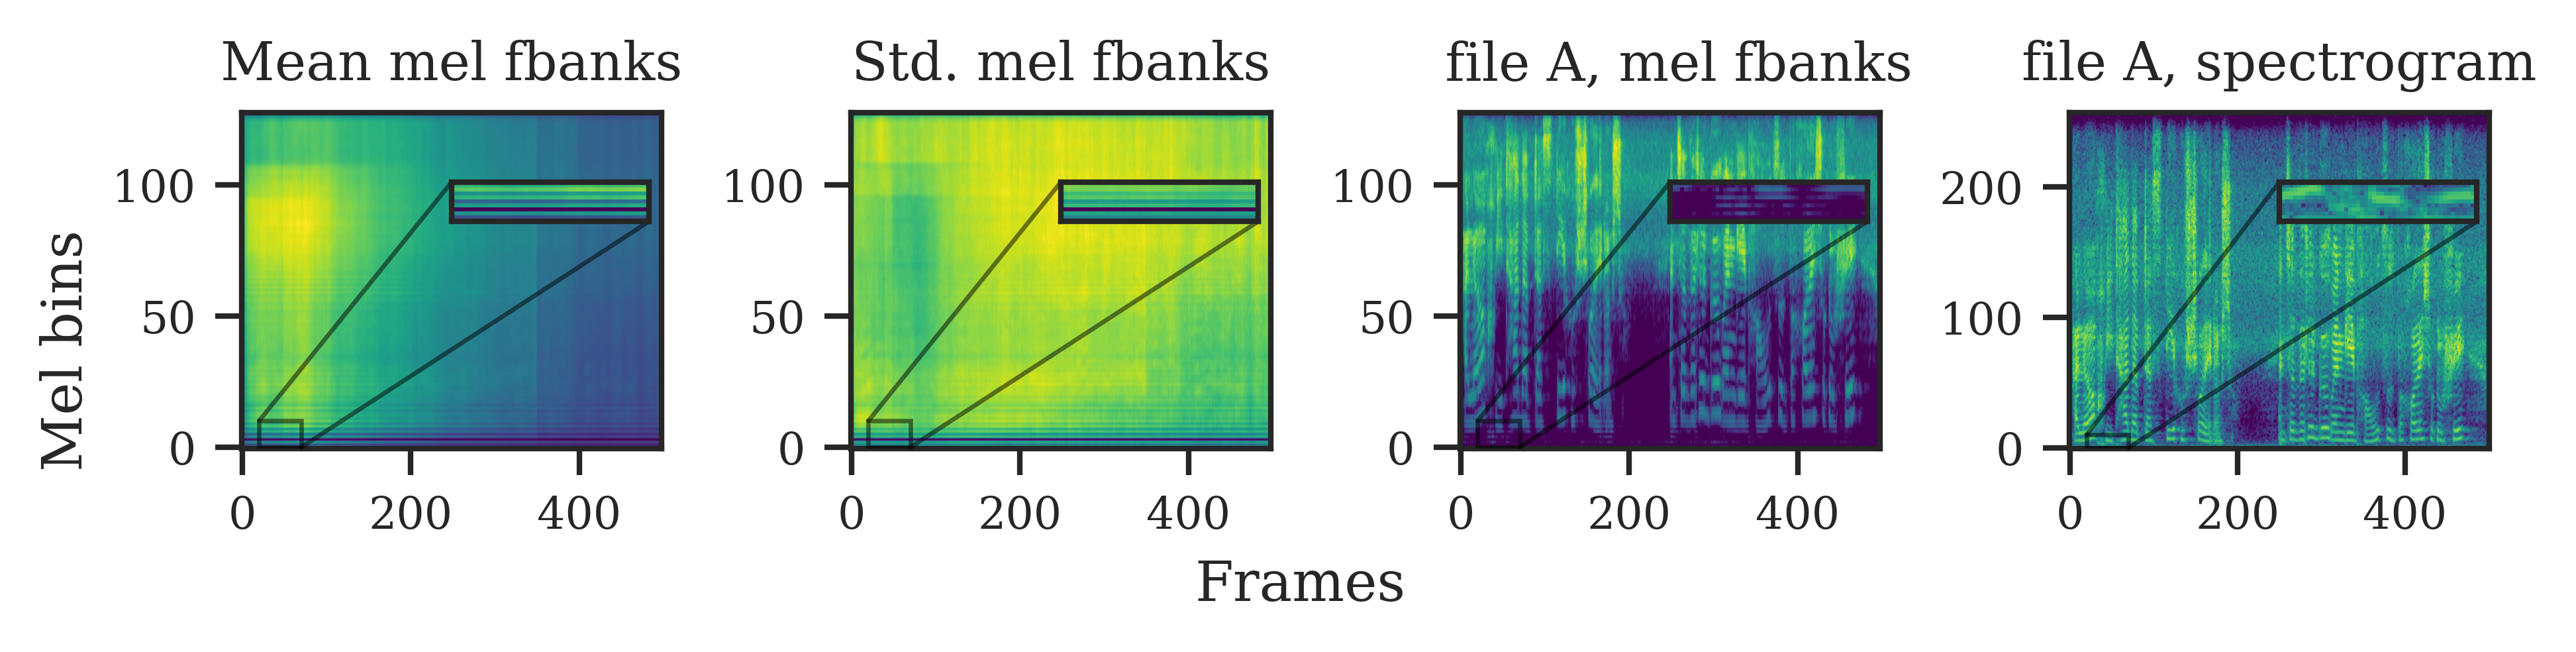

In [233]:
path_to_data = "../data/processed/WSA1K/train_498x128"
file_names = ["mean.pt", "std.pt", "1c934ca78a86af3748af9f7c7222eb21.pt", "1c934ca78a86af3748af9f7c7222eb21.pt"]
res_titles = ["Mean mel fbanks", "Std. mel fbanks", " file A, mel fbanks", "file A, spectrogram"]
i = 0
pf.set_style()
fig, axes = plt.subplots(1,4, figsize=(pf.set_size("project", fraction=1, height_ratio=0.4)))
for res, ax in zip(file_names, axes.ravel()):
    spec_path = os.path.join(*[path_to_data, res])
    if i == 0 or i==1:
        spec = torch.load(spec_path).T
    elif i==2:
        spec=spec3
    else:
        spec=spec1
    im = ax.imshow(spec, origin='lower', aspect='auto', cmap="viridis")
    
    axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
    axins.imshow(spec, origin="lower", cmap="viridis")
    x1, x2, y1, y2 = 20, 70, 0, 10
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    axins.get_xaxis().set_visible(False)
    axins.get_yaxis().set_visible(False)
    axins.grid(False)
    ax.indicate_inset_zoom(axins, edgecolor="black")
    ax.set_title(res_titles[i])
    ax.grid(False)
    
    i += 1
#cb_ax = fig.add_axes([1, 0.19, 0.02, 0.47])
#cbar = fig.colorbar(im, cax=cb_ax)
fig.text(0.5, -0.005, 'Frames', ha='center')
fig.text(-0.005, 0.4, 'Mel bins', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig("docs/Filterbank_plots/16kHz_bad_bin.png", bbox_inches = 'tight')
plt.savefig("docs/Filterbank_plots/16kHz_bad_bin.eps", bbox_inches = 'tight')


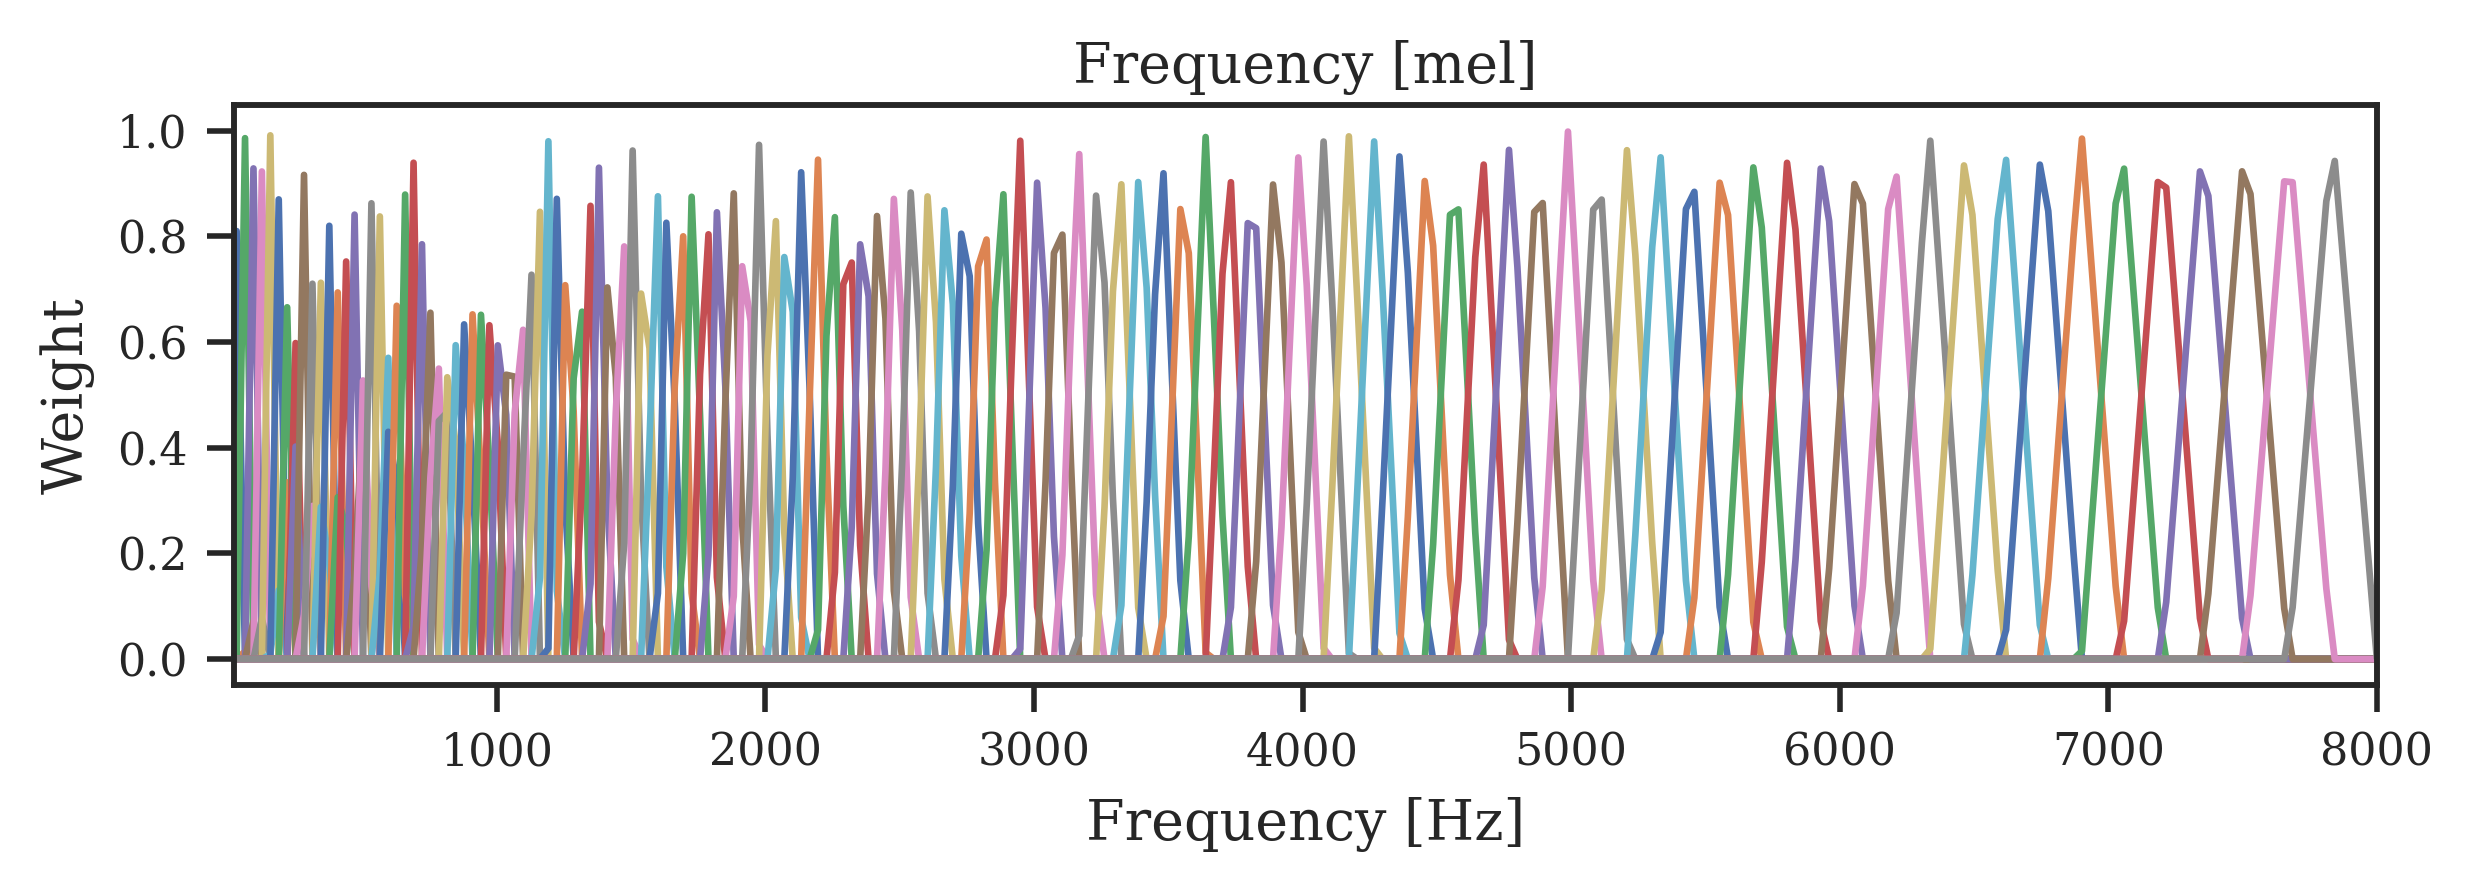

In [228]:

f1, f2 = 20, 8000
melmat, (melfreq, fftfreq) = melbank.compute_melmat(128, f1, f2, num_fft_bands=256)
pf.set_style()
fig, ax = plt.subplots(figsize=(pf.set_size("project", fraction=1, height_ratio=0.6)), dpi = 400)
ax.plot(fftfreq, melmat.T)
ax.grid(False)
ax.set_ylabel('Weight')
ax.set_xlabel('Frequency [Hz]')
ax.set_xlim((f1, f2))
ax2 = ax.twiny()
#ax2.xaxis.set_ticks_position('top')
ax2.set_xlim((f1, f2))
ax2.xaxis.set_ticks([])
ax2.set_xlabel('Frequency [mel]')
ax2.grid(False)
plt.tight_layout()
plt.savefig("docs/Filterbank_plots/mel_bins_128.png")
plt.savefig("docs/Filterbank_plots/mel_bins_128.eps")

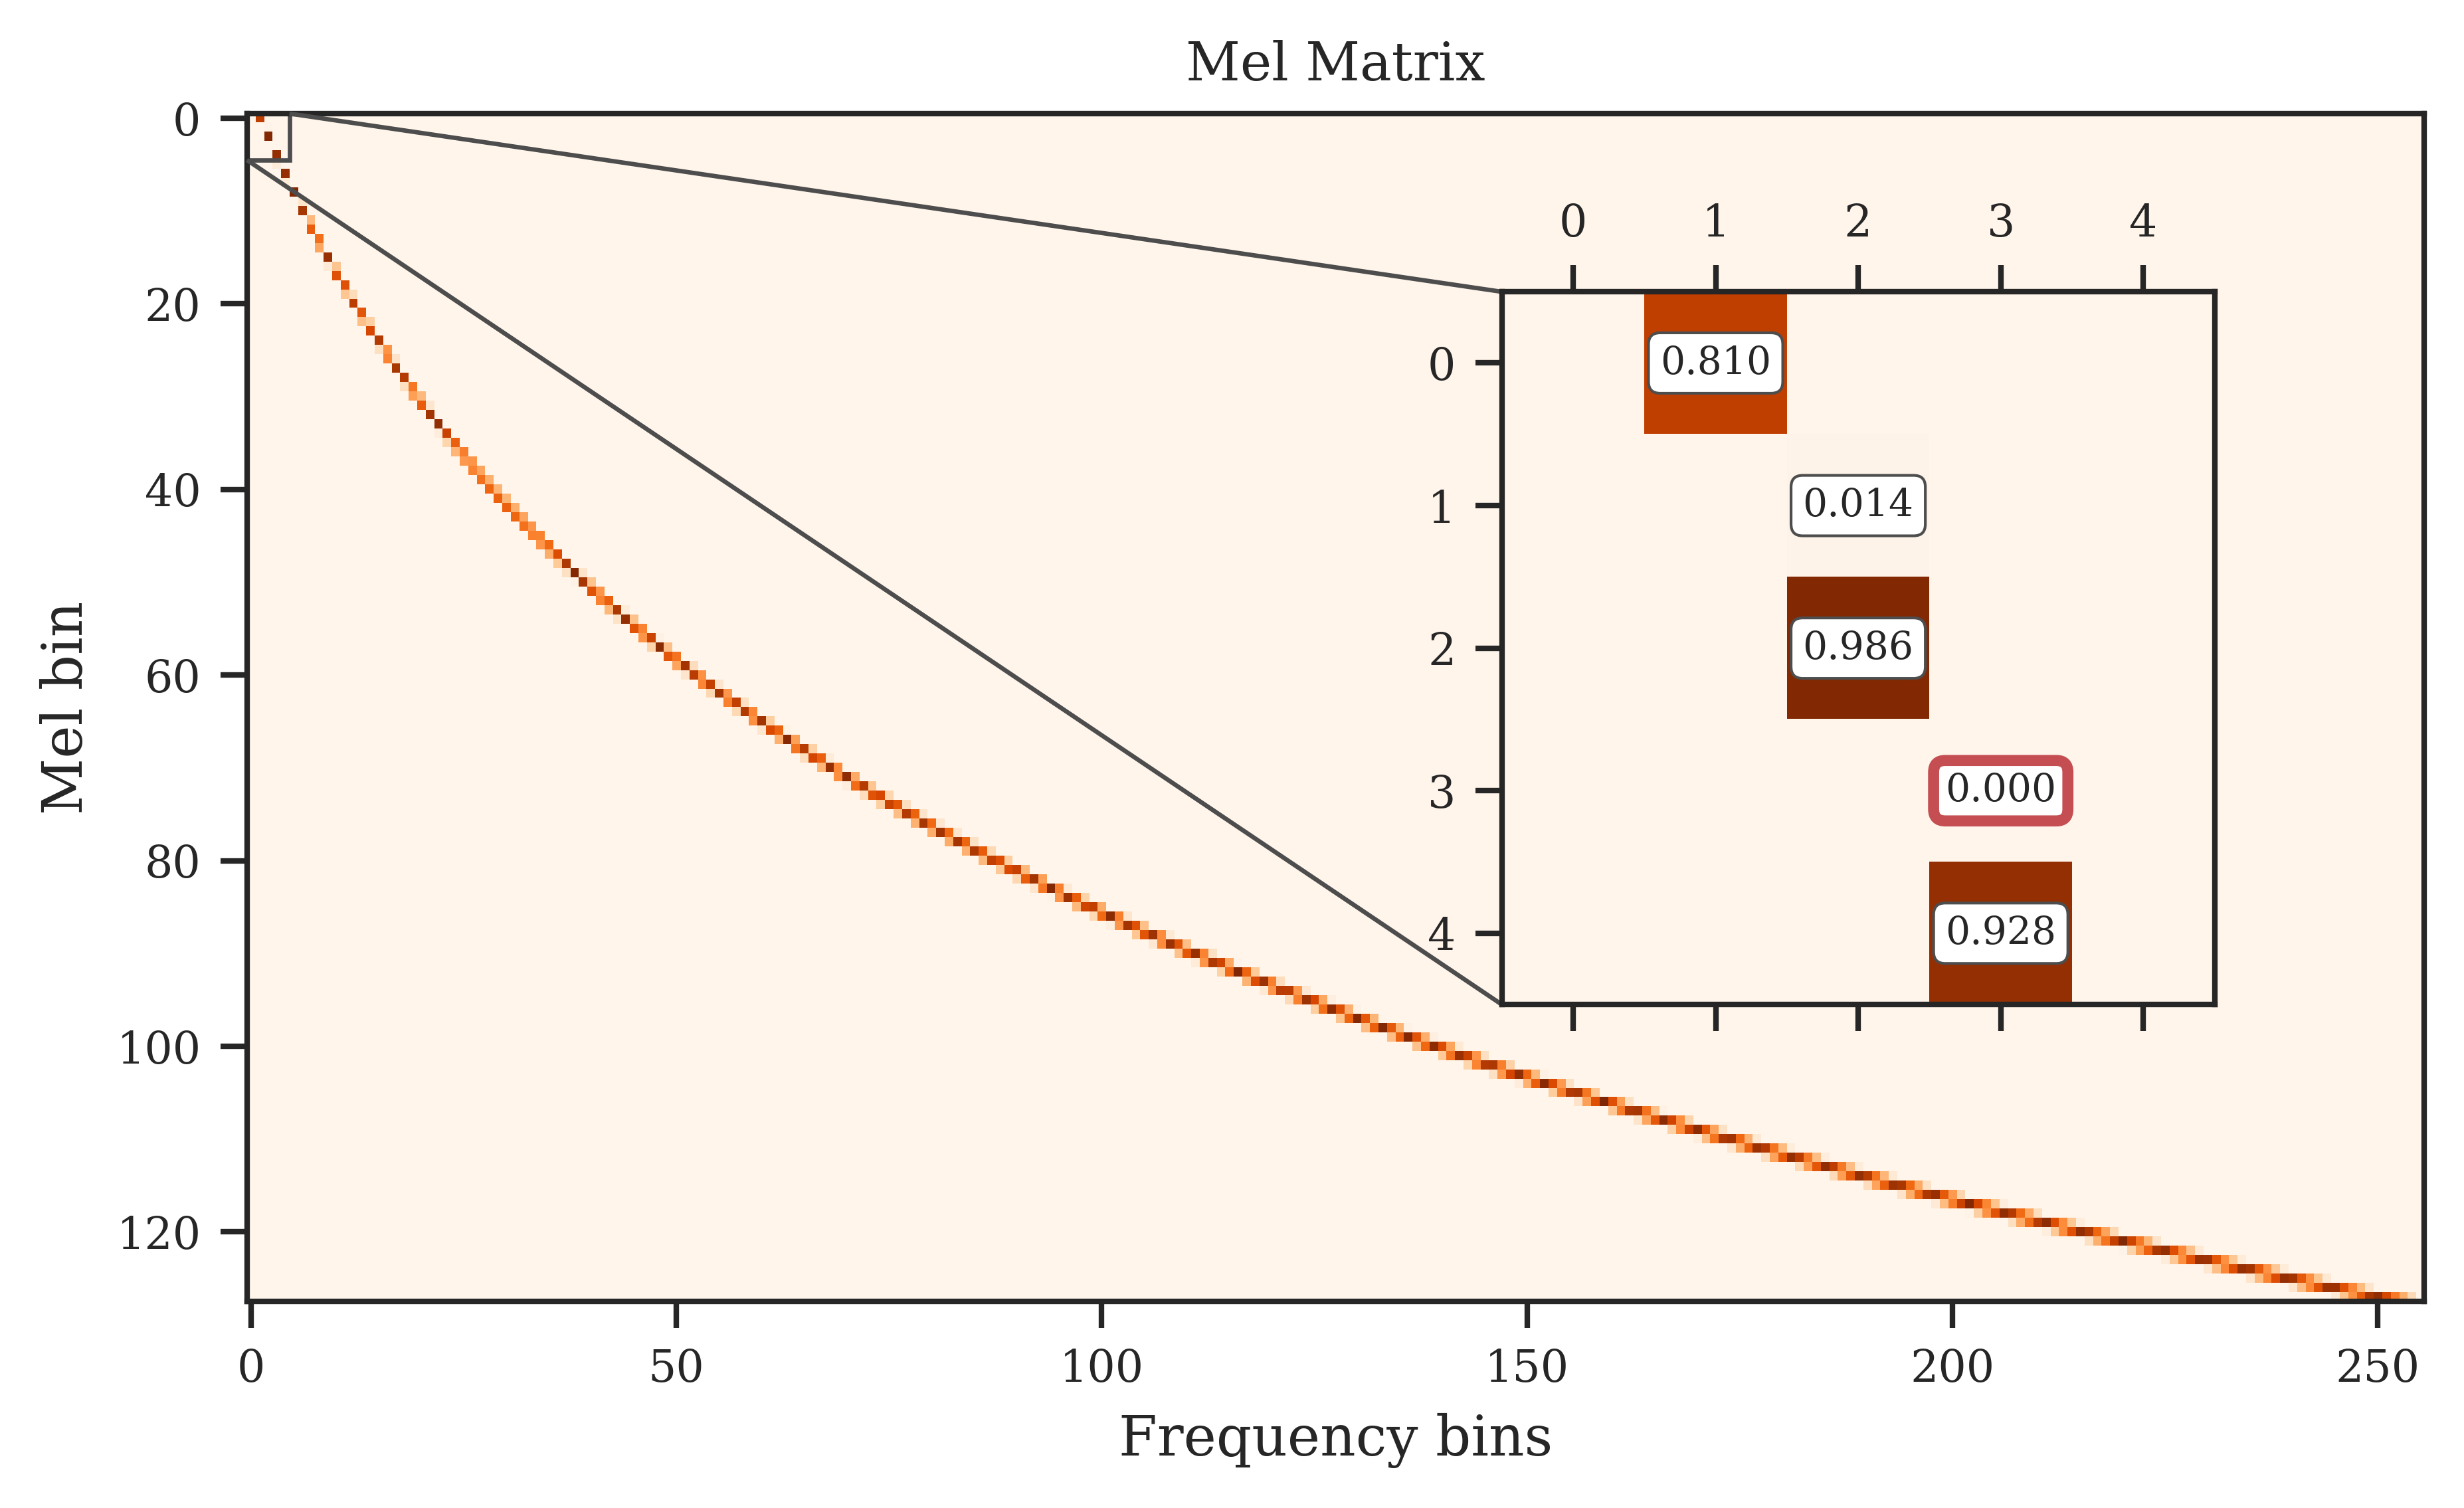

In [235]:
fig, ax = plt.subplots(figsize=(pf.set_size("project", fraction=1)))
ax.matshow(melmat, cmap="Oranges")
axins = ax.inset_axes([0.44, 0.25, 0.6, 0.6])
axins.matshow(melmat, cmap="Oranges")
x1, x2, y1, y2 = -0.5, 4.5, -0.5, 4.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.invert_yaxis()
axins.grid(False)
for (i, j), z in np.ndenumerate(melmat[:5,:5]):
    if (i,j) in [(0,1),(1,2), (2,2), (3,3),(4,3)]:
        ecolor='0.3'
        lw=0.5
        if (i==3) and (j==3):
            ecolor='r'
            lw=2
        axins.text(j, i, '{:0.3f}'.format(z), ha='center', va='center', size=7,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor=ecolor, linewidth=lw))
#ax.indicate_inset_zoom(axins, edgecolor="black")
patch, pp1,pp2 = mark_inset(ax, axins, loc1=1,loc2=1, edgecolor='0.3')
pp1.loc1 = 3
pp1.loc2 = 2
pp2.loc1 = 2
pp2.loc2 = 4
ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
ax.set(ylabel="Mel bin", xlabel="Frequency bins")
ax.grid(False)
plt.grid(False)
plt.axis('equal')
plt.axis('tight')
plt.title('Mel Matrix')
plt.tight_layout()
plt.savefig("docs/Filterbank_plots/16kHz_mel_matrix.png")
plt.savefig("docs/Filterbank_plots/16kHz_mel_matrix.eps")